# Определение возраста покупателей

## Описание
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
Контролировать добросовестность кассиров при продаже алкоголя.

## Задача

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# Исследовательский анализ данных

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [10]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


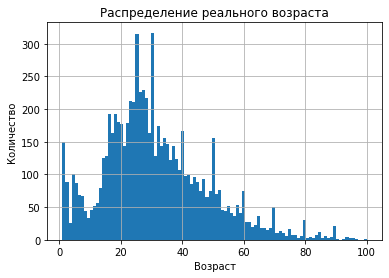

In [9]:
labels["real_age"].hist(bins=100)

plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение реального возраста')

plt.show();

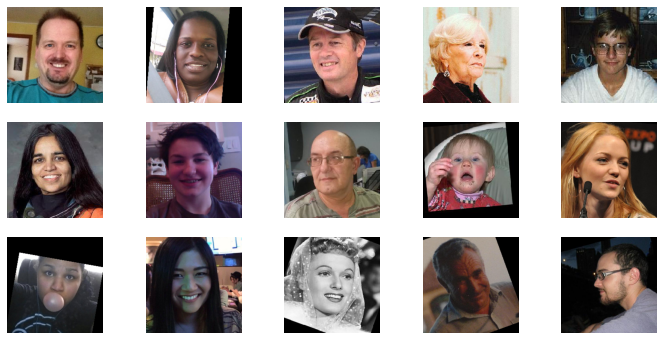

In [8]:
x_batch, y_batch = next(gen_flow)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12,6))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_batch[i])
    ax.axis('off')
plt.show()

__Выводы по исследовательскому анализу__    
Распределение возрастов похоже на нормальное, явных выбрасов нет  
Средний возраст людей - 31  
Минимальный возраст - 1  
Максимальный возраст - 100  
На фотография только лица людей, расположенные в центре  


## Обучение модели

```python
from tensorflow.keras import Sequential  
from tensorflow.keras.layers import Flatten, Dense,   GlobalAveragePooling2D  
import numpy as np  
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.applications.resnet import ResNet50  
import pandas as pd  


def load_train(path):  
    datagen = ImageDataGenerator(validation_split=0.25,   rescale=1./255)    
    labels = pd.read_csv(path + 'labels.csv')    
    train_datagen_flow =   datagen.flow_from_dataframe(dataframe=labels,  
                                                     directory=path + 'final_files/',   
                                                     x_col='file_name',  
                                                     y_col='real_age',  
                                                     target_size=(224, 224),   
                                                     batch_size=16,   
                                                     class_mode='raw',   
                                                     subset='training',  
                                                     seed=12345)    
    return train_datagen_flow  


def load_test(path):    
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)  
    labels = pd.read_csv(path + 'labels.csv')  
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=labels,  
                                                     directory=path + 'final_files/',   
                                                     x_col='file_name',  
                                                     y_col='real_age',   
                                                     target_size=(224, 224),   
                                                     batch_size=16,   
                                                     class_mode='raw',   
                                                     subset='validation',  
                                                     seed=12345)  
    return test_datagen_flow  


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu')) 
 
    optimizer = Adam(lr=0.0001) 
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:   
        validation_steps=len(test_data)
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

__Полученный результат__

```
2024-05-30 04:01:53.468545: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-05-30 04:01:53.471139: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2024-05-30 04:01:54.319809: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-05-30 04:01:54.328518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-05-30 04:01:54.328569: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-05-30 04:01:54.328600: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-05-30 04:01:54.331372: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-05-30 04:01:54.331852: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-05-30 04:01:54.335060: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-05-30 04:01:54.336409: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-05-30 04:01:54.336465: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-05-30 04:01:54.339427: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2024-05-30 04:01:54.635073: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-05-30 04:01:54.641398: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2024-05-30 04:01:54.641933: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4c61cb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-05-30 04:01:54.641959: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-05-30 04:01:54.786156: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x42c1fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-30 04:01:54.786195: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-05-30 04:01:54.787879: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-05-30 04:01:54.787932: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-05-30 04:01:54.787942: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-05-30 04:01:54.787970: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-05-30 04:01:54.787982: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-05-30 04:01:54.787993: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-05-30 04:01:54.788004: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-05-30 04:01:54.788012: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-05-30 04:01:54.791215: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-05-30 04:01:54.791312: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-05-30 04:01:55.113808: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-05-30 04:01:55.113855: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-05-30 04:01:55.113863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-05-30 04:01:55.117062: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-30 04:01:55.117108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 9s
   81920/94765736 [..............................] - ETA: 1:03
  262144/94765736 [..............................] - ETA: 40s 
  843776/94765736 [..............................] - ETA: 18s
 2310144/94765736 [..............................] - ETA: 8s 
 6356992/94765736 [=>............................] - ETA: 3s
10788864/94765736 [==>...........................] - ETA: 2s
14082048/94765736 [===>..........................] - ETA: 2s
18874368/94765736 [====>.........................] - ETA: 1s
23183360/94765736 [======>.......................] - ETA: 1s
27811840/94765736 [=======>......................] - ETA: 1s
32301056/94765736 [=========>....................] - ETA: 1s
35594240/94765736 [==========>...................] - ETA: 1s
40271872/94765736 [===========>..................] - ETA: 0s
44630016/94765736 [=============>................] - ETA: 0s
49037312/94765736 [==============>...............] - ETA: 0s
53690368/94765736 [===============>..............] - ETA: 0s
57090048/94765736 [=================>............] - ETA: 0s
61358080/94765736 [==================>...........] - ETA: 0s
66109440/94765736 [===================>..........] - ETA: 0s
69419008/94765736 [====================>.........] - ETA: 0s
73891840/94765736 [======================>.......] - ETA: 0s
78422016/94765736 [=======================>......] - ETA: 0s
82591744/94765736 [=========================>....] - ETA: 0s
87343104/94765736 [==========================>...] - ETA: 0s
90865664/94765736 [===========================>..] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/5
2024-05-30 04:02:07.420701: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-05-30 04:02:07.741190: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 67s - loss: 200.1680 - mae: 10.2770 - val_loss: 756.2251 - val_mae: 22.5706
Epoch 2/5
356/356 - 41s - loss: 69.4412 - mae: 6.3071 - val_loss: 115.0539 - val_mae: 8.1226
Epoch 3/5
356/356 - 41s - loss: 37.5477 - mae: 4.7472 - val_loss: 74.6731 - val_mae: 6.5331
Epoch 4/5
356/356 - 40s - loss: 23.8174 - mae: 3.7985 - val_loss: 93.1400 - val_mae: 7.2096
Epoch 5/5
356/356 - 41s - loss: 17.0603 - mae: 3.2022 - val_loss: 69.5991 - val_mae: 6.2433
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 69.5991 - mae: 6.2433  
__Test MAE: 6.2433__
```

Получили метрику качества МАЕ - 6.24. Модель в среднем ошибается на это значение при прогнозе возраста. Данное значение метрики проходит указанный порог в 7

## Вывод

В этом проекте мы провели исследовательский анализ и построили модель, позволяющую предсказывать возраст покупателей. Получили метрику качества MAE в 6.12, что является хорошим результатом.